In [1]:
from torch import nn, optim
import os
import shapely
import pandas as pd
import geopandas as gpd
import numpy as np
from numpy.random import default_rng
import torch
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import libpysal
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [3]:
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Device: {}".format(device))

Device: cpu


In [4]:
df15 = load_data(2015).set_index("C28992R100")
df16 = load_data(2016).set_index("C28992R100")
df17 = load_data(2017).set_index("C28992R100")
df18 = load_data(2018).set_index("C28992R100")
df19 = load_data(2019).set_index("C28992R100")


In [5]:
# Get data that is available in all years
overlapping1517 = df17.index[df17.index.isin(df16.index[df16.index.isin(df15.index)])]
overlapping1518 = df18.index[df18.index.isin(overlapping1517)]
overlapping1519 = df19.index[df19.index.isin(overlapping1518)]

# Fill X and Y
X = np.zeros((len(overlapping1519), 5, 40))
Y = np.zeros((len(overlapping1519), 5))
Y_1 = np.zeros((len(overlapping1519), 5))
ss = StandardScaler()

for i, df in enumerate([df15, df16, df17, df18, df19]):
    X[:,i] = df[df.columns[:-3]].loc[overlapping1519]
    Y[:,i] = df.loc[overlapping1519]["y"]
    Y_1[:,i] = df.loc[overlapping1519]["y-1"]


In [6]:
# Create neighbor lists for all years

df15 = df15.loc[overlapping1519]
df16 = df16.loc[overlapping1519]
df17 = df17.loc[overlapping1519]
df18 = df18.loc[overlapping1519]
df19 = df19.loc[overlapping1519]


w15 = libpysal.weights.DistanceBand.from_dataframe(df15.reset_index(), threshold=150, binary = True, silence_warnings = True)
w16 = libpysal.weights.DistanceBand.from_dataframe(df16.reset_index(), threshold=150, binary = True, silence_warnings = True)
w17 = libpysal.weights.DistanceBand.from_dataframe(df17.reset_index(), threshold=150, binary = True, silence_warnings = True)
w18 = libpysal.weights.DistanceBand.from_dataframe(df18.reset_index(), threshold=150, binary = True, silence_warnings = True)
w19 = libpysal.weights.DistanceBand.from_dataframe(df19.reset_index(), threshold=150, binary = True, silence_warnings = True)

In [7]:
# create Y(t-1) for all years

def get_y_1(y1, w):
    neighbors = [w.neighbors[x] for x in w.neighbors]
    y1 = np.array([y1[x].sum() for x in neighbors])
    y1[np.where(y1 == 0)[0]] = 0.5

    return y1

Y1_15 = get_y_1(Y_1[:,0], w15)
Y1_16 = get_y_1(Y_1[:,1], w16)
Y1_17 = get_y_1(Y_1[:,2], w17)
Y1_18 = get_y_1(Y_1[:,3], w18)
Y1_19 = get_y_1(Y_1[:,4], w19)



In [8]:
rng = default_rng()
def get_batch(X, Y, Y1, batch_size = 32):
    idxs = rng.integers(len(X), size = batch_size)
    return X[idxs], Y[idxs], Y1[idxs]



In [9]:
# X train is the first three years
X_train = X[:,:3]

#fill X_train Y(t-1) with actual values for resampling
X_train[:,0,39] = Y1_15
X_train[:,1,39] = Y1_16
X_train[:,2,39] = Y1_17

X_train = X_train.reshape(-1, 40*3)


Y_train = Y[:,2]


In [10]:
# oversample X_train using SMOTE

smote = SMOTE()
X_train_resample,Y_train_resample = smote.fit_resample(X_train,Y_train)
X_train = X_train.reshape(-1,3,40)
X_train_resample = X_train_resample.reshape(-1,3,40)

# transform Y(t-1) to proper values

Y1_17r = X_train_resample[:,2,-1]
Y1_17r[Y1_17r>0.5] =  np.ceil(Y1_17r[Y1_17r > 0.5])

X_train_resample = np.delete(X_train_resample, -1, 2)
X_train = np.delete(X_train, -1, 2)

X_train = X_train.reshape(-1, 39)
X_train_resample = X_train_resample.reshape(-1, 39)

# Fit and transform the standard scaler
X_train = ss.fit_transform(X_train)
X_train_resample = ss.transform(X_train_resample)

X_train_resample = X_train_resample.reshape(-1,3, 39)

Y1_17r = torch.tensor(Y1_17r).float().to(device).to(device)
Y1_18 = torch.tensor(Y1_18).float().to(device).to(device)

In [11]:
# create X_val and X_test
X_val = X[:,:4]
Y_val = Y[:,3]
X_val = np.delete(X_val, -1, 2)

X_val = X_val.reshape(-1, 39)
X_val = ss.transform(X_val)
X_val = X_val.reshape(-1, 4, 39)



X_test = X[:,:5]
Y_test = Y[:,4]
X_test = np.delete(X_test, -1, 2)
X_test = X_test.reshape(-1, 39)

X_test = ss.transform(X_test)
X_test = X_test.reshape(-1, 5, 39)

X_val = torch.tensor(X_val).float().to(device)
X_test = torch.tensor(X_test).float().to(device)




In [12]:
Y_val = torch.tensor(Y_val).float().to(device)
X_train_resample = torch.tensor(X_train_resample).float().to(device)
Y_train_resample = torch.tensor(Y_train_resample).float().to(device)


In [13]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.GRU = nn.GRU(input_size = 39, dropout = 0.2,num_layers = 2,hidden_size = 20, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(20,1),

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(2, X.size(0), 20)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        return X


In [14]:
class RNN1(nn.Module):
    def __init__(self):
        super(RNN1, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 20, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(20,1),

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 20)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [15]:
class RNN2(nn.Module):
    def __init__(self):
        super(RNN2, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 100)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [16]:
class RNN3(nn.Module):
    def __init__(self):
        super(RNN3, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 2,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(2, X.size(0), 100)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [17]:
class RNN4(nn.Module):
    def __init__(self):
        super(RNN4, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 50, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(50,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.ReLU(),
            nn.Linear(50,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 50)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [18]:
class RNN5(nn.Module):
    def __init__(self):
        super(RNN5, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 50, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(50,150),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(150,150),
            nn.ReLU(),
            nn.Linear(150,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 50)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [19]:
model = RNN().to(device)
model1 = RNN1().to(device)
model2 = RNN2().to(device)
model3 = RNN3().to(device)
model4 = RNN4().to(device)
model5 = RNN5().to(device)

models = [2]

In [22]:
def train(models, X_train, Y_train, Y1_train, X_val, Y_val, Y1_val, num_epochs, lr, batch_per_e = 100 ):

    best_auc, best_f1, best_model, best_epoch, best_lr = 0,0,0,0,0
    
    for i, model in enumerate(models):
#         for lr in [0.00000051, 0.0000051]:
        for lr in [0.0000051]:
                
            if model == 0: model = RNN()         
            elif model ==1: model = RNN1()                
            elif model == 2: model = RNN2()
            elif model == 3: model = RNN3()
            elif model == 4: model = RNN4()
            else: model = RNN5()
           
            ROC_history = []     
            optimizer = optim.Adam(model.parameters(), lr=lr) 
            SigBCEloss = nn.BCEWithLogitsLoss()
            
            for epoch in range(num_epochs):
                epoch_loss = []
#                 print("epoch: {} of {}".format(epoch, num_epochs))
                for batch in range(batch_per_e):

                    x, y, y1 = get_batch(X_train, Y_train, Y1_train, 6)

                    model.train()

                    optimizer.zero_grad()
                    out = model(x, y1).squeeze()


                    loss = SigBCEloss(out, y)
                    loss.backward()
                    optimizer.step()


                    epoch_loss.append(loss.detach().numpy())

                model.eval()

                out = model(X_val, Y1_val)
                ROC = roc_auc_score(Y_val, model.final(out).detach().numpy())
                out = out.squeeze().detach().numpy()

                preds = np.zeros(len(out))
                pos = out.argsort()[-((Y_val == 1).sum()):]
                preds[pos] = 1
                
                f1 = f1_score(Y_val, preds)

                ROC_history.append(ROC)

                if ROC > best_auc:
                    print("model: {}, ROC:{}, f1: {}, lr: {}, epoch = {}".format(i, ROC, f1, lr, epoch))
                    best_auc = ROC
                    best_f1 = f1
                    best_model = deepcopy(model.state_dict())
                    best_epoch = epoch
                    best_lr = lr

                train_loss = []
                          
            print(np.max(ROC_history), np.argmax(ROC_history), lr)
            plt.plot(ROC_history, alpha = 0.5)
            plt.hlines(np.mean(ROC_history), 0, n_epochs, color = "r") 
            linear_model=np.polyfit(range(n_epochs), ROC_history, 2)
            linear_model_fn=np.poly1d(linear_model)
            x_s=np.arange(0,n_epochs)
            plt.plot(linear_model_fn(x_s))  
            plt.show()
                          
    result = np.argmax(ROC_history)
    return best_auc, best_f1, best_model, best_epoch

model: 0, ROC:0.6348374427464577, f1: 0.29102564102564105, lr: 5.1e-06, epoch = 0
model: 0, ROC:0.6404323712597919, f1: 0.29743589743589743, lr: 5.1e-06, epoch = 1
model: 0, ROC:0.6440924510937032, f1: 0.3, lr: 5.1e-06, epoch = 2
model: 0, ROC:0.6482407020960861, f1: 0.29935897435897435, lr: 5.1e-06, epoch = 3
model: 0, ROC:0.6500748219967752, f1: 0.29743589743589743, lr: 5.1e-06, epoch = 4
model: 0, ROC:0.6523189914101851, f1: 0.30128205128205127, lr: 5.1e-06, epoch = 5
model: 0, ROC:0.6551523729007035, f1: 0.30256410256410254, lr: 5.1e-06, epoch = 6
model: 0, ROC:0.6574036321219126, f1: 0.30512820512820515, lr: 5.1e-06, epoch = 7
model: 0, ROC:0.6592657991238959, f1: 0.30833333333333335, lr: 5.1e-06, epoch = 8
model: 0, ROC:0.6613196138863918, f1: 0.31025641025641026, lr: 5.1e-06, epoch = 9
model: 0, ROC:0.6634060685187564, f1: 0.3121794871794872, lr: 5.1e-06, epoch = 10
model: 0, ROC:0.6646265856199078, f1: 0.31474358974358974, lr: 5.1e-06, epoch = 11
model: 0, ROC:0.666063497923890

model: 0, ROC:0.6982217067619821, f1: 0.36217948717948717, lr: 5.1e-06, epoch = 107
model: 0, ROC:0.6982931399198093, f1: 0.36346153846153845, lr: 5.1e-06, epoch = 114
model: 0, ROC:0.698653070288087, f1: 0.36282051282051286, lr: 5.1e-06, epoch = 115
model: 0, ROC:0.6988035614913746, f1: 0.36282051282051286, lr: 5.1e-06, epoch = 122
model: 0, ROC:0.6989928905726068, f1: 0.36217948717948717, lr: 5.1e-06, epoch = 123
model: 0, ROC:0.699005286588759, f1: 0.36282051282051286, lr: 5.1e-06, epoch = 124
model: 0, ROC:0.6990634319307107, f1: 0.36217948717948717, lr: 5.1e-06, epoch = 127
model: 0, ROC:0.6991266605310845, f1: 0.36346153846153845, lr: 5.1e-06, epoch = 128
model: 0, ROC:0.6992541878915001, f1: 0.36346153846153845, lr: 5.1e-06, epoch = 129
model: 0, ROC:0.6992893693905798, f1: 0.36346153846153845, lr: 5.1e-06, epoch = 137
model: 0, ROC:0.6993015870467874, f1: 0.36346153846153845, lr: 5.1e-06, epoch = 138
model: 0, ROC:0.6994275983476734, f1: 0.3615384615384615, lr: 5.1e-06, epoch =

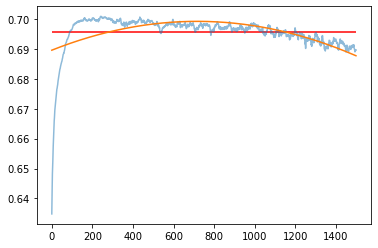

In [23]:
n_epochs = 1500
hists = train(models, X_train_resample, Y_train_resample, Y1_17r, X_val, Y_val, Y1_18, n_epochs, 0.0000051)

best model: model 2, auc = 0.(0.7132703366008875,

f1: 0.3506410256410256,, lr =  5.1e-06

In [30]:
model = RNN2()
model.load_state_dict(hists[2])
model.eval()

out = model(X_test, torch.tensor(Y1_19))

ROC = roc_auc_score(Y_test, model.final(out).detach().numpy())
out = out.squeeze().detach().numpy()

preds = np.zeros(len(out))
pos = out.argsort()[-((Y_test == 1).sum()):]
preds[pos] = 1

f1 = f1_score(Y_test, preds)
print(ROC, f1)
with open ("../Results/Denhaag.csv", "a+") as f:
    f.write("RNN,{},{}".format(ROC,f1))

0.6761051454541094 0.4014227642276423


0.6110970206754848 178


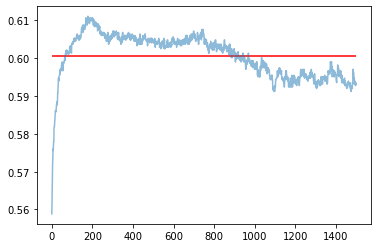

In [72]:
print(np.max(hists[-4]), np.argmax(hists[-4]))
plt.plot(hists[-4], alpha = 0.5)
plt.hlines(np.mean(hists[-4]), 0, n_epochs, color = "r")